# Project : Amazon Fine Food Reviews.

In [1]:
# import the libarys

import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import re
import string
import os
import pickle

from sklearn.feature_extraction.text import TfidfTransformer , TfidfVectorizer , CountVectorizer

from sklearn.metrics import confusion_matrix , roc_curve

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec , KeyedVectors

from tqdm import tqdm

### Read the file

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('G:/Software/Machine learning/Datasets/Amazon food review/database.sqlite') 

dataset_sqlite = pd.read_sql_query("""
                                    SELECT * FROM Reviews where Score != 3
                                    """ , con)

In [3]:
def partition(x):
    if x < 3:
        return 'negetive'
    
    return 'positive'

In [4]:
actual_score = dataset_sqlite['Score']
positiveNegetive = actual_score.map(partition)
dataset_sqlite['Score'] = positiveNegetive

In [5]:
dataset_sqlite.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negetive,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negetive,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,positive,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,positive,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,positive,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,positive,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [6]:
dataset_sqlite.shape

(525814, 10)

In [7]:
dataset_sqlite.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525814 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null object
Time                      525814 non-null int64
Summary                   525814 non-null object
Text                      525814 non-null object
dtypes: int64(4), object(6)
memory usage: 40.1+ MB


In [8]:
dataset_sqlite.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [9]:
amnt_pos = dataset_sqlite.Score.value_counts()['positive']
amnt_neg = dataset_sqlite.Score.value_counts()['negetive']

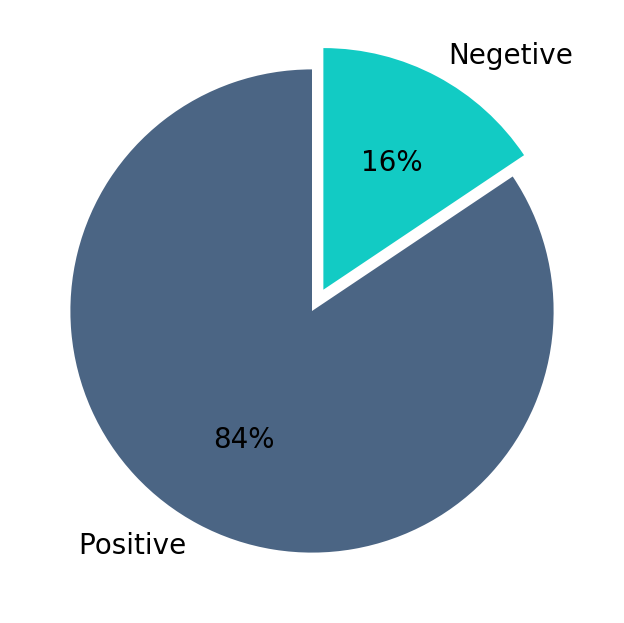

In [10]:
category_names = ['Positive' , 'Negetive']
sizes = [amnt_pos , amnt_neg]
custom_colours = ['#4b6584', '#12CBC4']

plt.figure(figsize = (10,8) , dpi=100)
plt.pie(sizes, labels=category_names , textprops={'fontsize': 20} , startangle = 90 , 
       autopct='%1.0f%%' , colors=custom_colours , explode=[0 , 0.1])

plt.show()

## Data Cleaning

In [11]:
display = pd.read_sql_query("""

                            select * from Reviews ORDER BY UserId
                            
                            """ , con)

display.head(15)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,136323,B006Q820X0,#oc-R103C0QSV1DF5E,C,1,2,5,1343088000,Great for the Price,I have to say I was a little apprehensive to b...
1,516062,B008I1XPKA,#oc-R109MU5OBBZ59U,AayGee,0,1,5,1350086400,AWESOME Coffee!!!!,Received my free K cups as a sample promotion ...
2,516079,B008I1XPKA,#oc-R10LFEMQEW6QGZ,Julie,0,1,5,1345939200,Brooklyn Bean Roastery Breakfast Blend K-Cups,Brooklyn Bean Roastery Blend K-Cups are great ...
3,378693,B0026LJ3EA,#oc-R10LT57ZGIB140,dipr,0,0,3,1310601600,Some damage,The shipment of the dog food was quick. Howev...
4,136545,B006Q820X0,#oc-R10UA029WVWIUI,Kim D,0,0,1,1342483200,Less than satisfactory. I gave the Brooklyn K...,"Brooklyn ""French Roast"" K-Cup Coffee is not on..."
5,83318,B005ZBZLT4,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
6,180872,B007Y59HVM,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...
7,21719,B005DVVB9K,#oc-R119LM8D59ZW8Y,"Lee Mellott ""SEOmenu2go""",5,11,1,1320192000,Not So Sweet Treat!,I love chocolate so I was excited to see the C...
8,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
9,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


There have been many duplicates rows in the dataset.In the above table 8,9,10 rows have similar customer and he buy different product and review it at the same time.So it can be a garbage value.There can be some miscalculation when save it into the database.So it is necessasry to remove those rows for better performance.

In [12]:
display = pd.read_sql_query("""

                            select * from Reviews where Score !=3 and UserId="#oc-R11D9D7SHXIJB9" ORDER BY ProductID
                            
                            """ , con)

display.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
1,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
2,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


Check how many product the perticular customer but at a same time.


Check some other Users

In [13]:
display= pd.read_sql_query("""

                        select *
                        from Reviews
                        where Score != 3 AND UserId = "AR5J8UI46CURR"
                        ORDER BY ProductID
                        
                        """, con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


It is shown that this customer also have buy many different product at the same time and review it.This can be happen when a specific product have different color or differnet flavor.
So remove the duplicate all rows.

In [14]:
# Sorting the dataset according to productID

sorted_data = dataset_sqlite.sort_values(
                        'ProductId' , axis = 0 , ascending = True , inplace = False , kind = 'quicksort' ,  na_position='last'
                        )
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


Find the duplicates if the useid , profilename , time , text is the same then it is duplicate.And remove those rows.

In [15]:
#Deduplication of entries

final = sorted_data.drop_duplicates(subset = {'UserId' , 'ProfileName' , 'Time' , 'Text'} , keep = 'first' , inplace = False)
final.shape

(364173, 10)

In [16]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0) / (dataset_sqlite['Id'].size*1.0) * 100

69.25890143662969

After removing those duplicates rows we hvae 69% data remaining.

Another way to fina inconsistency in the dataset is if the <b>HelpfulnessNumerator</b> is greater than <b>HelpfulnessDenominator</b>

In [17]:
display= pd.read_sql_query("""

                        SELECT *
                        FROM Reviews
                        WHERE HelpfulnessNumerator > HelpfulnessDenominator
                        
                        """, con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [18]:
display= pd.read_sql_query("""

                        SELECT *
                        FROM Reviews
                        WHERE Score != 3 AND Id=44737 OR Id=64422
                        ORDER BY ProductID
                        
                        """, con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [19]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [20]:
final.shape

(364171, 10)

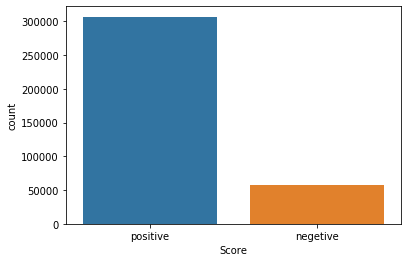

In [21]:
sns.countplot(x = 'Score' , data = final)

## Text Preprocessing